In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import hdbscan
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import pairwise_distances
import warnings

#from utils import *

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
sns.set(style='ticks')

In [5]:
kids_x_sdss = pd.read_csv('/home/kasia/Data/KiDS/KiDS.DR4.x.SDSS.DR14.csv')

In [6]:
kids_x_sdss_sample = pd.read_csv('/home/kasia/Data/KiDS/kids_x_sdss_sample.csv')

In [6]:
BANDS = ['u', 'g', 'r','i', 'Z','Y','J','H','Ks']
mag_cols = ['MAG_GAAP_{}'.format(m) for m in BANDS]
colours = ['COLOUR_GAAP_u_g',
 'COLOUR_GAAP_g_r',
 'COLOUR_GAAP_r_i',
 'COLOUR_GAAP_i_Z',
 'COLOUR_GAAP_Z_Y',
 'COLOUR_GAAP_Y_J',
 'COLOUR_GAAP_J_H',
 'COLOUR_GAAP_H_Ks']

In [7]:
def clean_kids(data, bands=BANDS, with_print=True):
    # Drop NANs
    band_columns = get_mag_gaap_cols(bands)
    data_no_na = data.dropna(subset=band_columns).reset_index(drop=True)

    if with_print:
        n_left = data_no_na.shape[0]
        p_left = data_no_na.shape[0] / data.shape[0] * 100
        print('Droping NANs: {} ({:.2f}%) left'.format(n_left, p_left))

    mask = [True] * data_no_na.shape[0]

    # Remove errors
    magerr_gaap_columns = get_magerr_gaap_cols(bands)
    for c in magerr_gaap_columns:
        mask &= (data_no_na[c] < 1)
    if with_print:
        n_left = mask.sum()
        p_left = mask.sum() / data.shape[0] * 100
        print('Removing errors bigger than 1: {} ({:.2f}%) left'.format(n_left, p_left))

    # Survey limiting magnitudes
    # mask &= (
    #         (data_no_na['MAG_GAAP_U'] < 24.3) &
    #         (data_no_na['MAG_GAAP_G'] < 25.1) &
    #         (data_no_na['MAG_GAAP_R'] < 24.9) &
    #         (data_no_na['MAG_GAAP_I'] < 23.8)
    # )
    # if with_print:
    #     n_left = mask.sum()
    #     p_left = mask.sum() / data.shape[0] * 100
    #     print('Removing limiting magnitudes: {} ({:.2f}%) left'.format(n_left, p_left))

    # Remove flags
    flags_gaap = get_flags_gaap_cols(bands)
    for c in flags_gaap:
        mask &= (data_no_na[c] == 0)
    if with_print: print('Removing GAAP flags: {} left'.format(mask.sum()))

    # Remove ima-flags
    flag_mask = 0b0111111
    mask &= (data_no_na['IMAFLAGS_ISO'] & flag_mask == 0)
    if with_print:
        n_left = mask.sum()
        p_left = mask.sum() / data.shape[0] * 100
        print('Removing IMA flags: {} ({:.2f}%) left'.format(n_left, p_left))

    return data_no_na.loc[mask].reset_index(drop=True)

In [8]:
def get_mag_gaap_cols(bands=BANDS):
    return [get_mag_str(band) for band in bands]

In [9]:
def get_magerr_gaap_cols(bands=BANDS):
    return [get_magerr_str(band) for band in bands]

In [10]:
def get_magerr_str(band):
    return 'MAGERR_GAAP_{}'.format(band)

In [11]:
def get_flags_gaap_cols(bands=BANDS):
    return [get_flag_gaap_str(band) for band in bands]

In [12]:
def get_flag_gaap_str(band):
    return 'FLAG_GAAP_{}'.format(band)

In [13]:
def get_mag_str(band):
    return 'MAG_GAAP_{}'.format(band)

In [14]:
def clean_sdss(data, with_print=True):
    data_cleaned = data.loc[data['ZWARNING'] == 0].reset_index(drop=True)
    if with_print: print('Cleaning SDSS: {} left'.format(data_cleaned.shape[0]))
    return data_cleaned

In [15]:
def all_colours(data):
    magnitudes = ['u', 'g', 'r','i', 'Z','Y','J','H','Ks']
    for i, m_1 in enumerate(magnitudes):
        for j in range(i+1,len(magnitudes)):
            m_2 = magnitudes[j]
            subtrack = m_1 + '-' + m_2
            data.loc[:, 'col_{}'.format(subtrack)] = data.loc[:, 'MAG_GAAP_{}'.format(m_1)]-data.loc[:, 'MAG_GAAP_{}'.format(m_2)]
    
    return data

In [16]:
#funkcja zmieniająca typ kolumny SG2DPHOT
def process_sg2dphot(data):
    # 0 = all other sources (e.g. including galaxies).
    # 1 = high confidence star candidate;
    # 2 = unreliable source (e.g. cosmic ray);
    # 4 = star according to star/galaxy separation criteria;
    # Sources identified as stars can thus have a flag value of 1, 4 or 5.
    data.loc[:, 'SG2DPHOT'] = data['SG2DPHOT'].astype(int)
    data.loc[:, 'SG2DPHOT_1'] = data['SG2DPHOT'] & 0b001
    data.loc[:, 'SG2DPHOT_2'] = data['SG2DPHOT'] & 0b010
    data.loc[:, 'SG2DPHOT_4'] = data['SG2DPHOT'] & 0b100
    return data

In [17]:
kids_x_sdss = clean_sdss(kids_x_sdss)
kids_x_sdss = clean_kids(kids_x_sdss)
# kids_x_sdss = kids_x_sdss.dropna(subset=mag_cols)

Cleaning SDSS: 143057 left
Droping NANs: 122964 (85.95%) left
Removing errors bigger than 1: 121753 (85.11%) left
Removing GAAP flags: 121753 left
Removing IMA flags: 121323 (84.81%) left


In [18]:
kids_x_sdss = kids_x_sdss.sample(n=40000, random_state=3856790)

In [19]:
kids = pd.read_csv('/home/kasia/Data/KiDS/KiDS.DR4.500k.csv')

In [20]:
kids = clean_kids(kids)
# kids = kids.dropna(subset=mag_cols)

Droping NANs: 226903 (45.22%) left
Removing errors bigger than 1: 167995 (33.48%) left
Removing GAAP flags: 167995 left
Removing IMA flags: 167886 (33.46%) left


In [21]:
#kids_merged = kids.append(kids_x_sdss.loc[~kids['ID'].isin(kids_x_sdss['ID'])], sort=False)

kids = kids.loc[~kids['ID'].isin(kids_x_sdss['ID'])]
kids['CLASS'] = 'not SDSS'

In [22]:
kids = kids.sample(n=40000, random_state=1)
kids_merged = pd.concat([kids, kids_x_sdss], sort=False)

In [23]:
#czy tutaj mogą być te same nazwy zmiennych do w funkcji clustering - pelny zbior
magnitudes = kids_merged[mag_cols]
magnitudes_allfeatures = all_colours(magnitudes)
process_sg2dphot(kids_merged)
magnitudes_allfeatures.loc[:,'SG2DPHOT_4']=kids_merged.loc[:,'SG2DPHOT_4']
magnitudes_allfeatures.loc[:,'CLASS_STAR']=kids_merged.loc[:,'CLASS_STAR']

scaler = MinMaxScaler()
scaler.fit(magnitudes_allfeatures)
mag_rescaled_allfeatures = scaler.transform(magnitudes_allfeatures)

In [24]:
magnitudes_allfeatures.columns.tolist()

['MAG_GAAP_u',
 'MAG_GAAP_g',
 'MAG_GAAP_r',
 'MAG_GAAP_i',
 'MAG_GAAP_Z',
 'MAG_GAAP_Y',
 'MAG_GAAP_J',
 'MAG_GAAP_H',
 'MAG_GAAP_Ks',
 'col_u-g',
 'col_u-r',
 'col_u-i',
 'col_u-Z',
 'col_u-Y',
 'col_u-J',
 'col_u-H',
 'col_u-Ks',
 'col_g-r',
 'col_g-i',
 'col_g-Z',
 'col_g-Y',
 'col_g-J',
 'col_g-H',
 'col_g-Ks',
 'col_r-i',
 'col_r-Z',
 'col_r-Y',
 'col_r-J',
 'col_r-H',
 'col_r-Ks',
 'col_i-Z',
 'col_i-Y',
 'col_i-J',
 'col_i-H',
 'col_i-Ks',
 'col_Z-Y',
 'col_Z-J',
 'col_Z-H',
 'col_Z-Ks',
 'col_Y-J',
 'col_Y-H',
 'col_Y-Ks',
 'col_J-H',
 'col_J-Ks',
 'col_H-Ks',
 'SG2DPHOT_4',
 'CLASS_STAR']

In [24]:
classes, counts = np.unique(kids_merged['CLASS'], return_counts=True)

In [25]:
counts

array([27598,  4528,  7874, 40000])

In [27]:
classes

array(['GALAXY', 'QSO', 'STAR', 'not SDSS'], dtype=object)

In [24]:
def clustering(data):
    magnitudes = data[mag_cols]
    magnitudes_withoutclass_star = all_colours(magnitudes)
    process_sg2dphot(data)
    # magnitudes_withoutclass_star.loc[:,'SG2DPHOT_4']=data.loc[:,'SG2DPHOT_4']
    # magnitudes_allfeatures.loc[:,'CLASS_STAR']=data.loc[:,'CLASS_STAR']

    # print(magnitudes_allfeatures.columns.tolist())
    
    scaler = MinMaxScaler()
    scaler.fit(magnitudes_withoutclass_star)
    mag_rescaled_withoutclass_star = scaler.transform(magnitudes_withoutclass_star)    

    clusterer = hdbscan.HDBSCAN(min_cluster_size=22, min_samples=16)
    clusterer.fit(mag_rescaled_withoutclass_star)

    data['cluster'] = clusterer.labels_
    return data

In [25]:
def clustering_parameters(data,i,j):
    magnitudes = data[mag_cols]
    magnitudes_withoutclass_star = all_colours(magnitudes)
    process_sg2dphot(data)
    # magnitudes_withoutclass_star.loc[:,'SG2DPHOT_4']=data.loc[:,'SG2DPHOT_4']
    # magnitudes_allfeatures.loc[:,'CLASS_STAR']=data.loc[:,'CLASS_STAR']

    # print(magnitudes_allfeatures.columns.tolist())
    
    scaler = MinMaxScaler()
    scaler.fit(magnitudes_withoutclass_star)
    mag_rescaled_withoutclass_star = scaler.transform(magnitudes_withoutclass_star)    

    clusterer = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j)
    clusterer.fit(mag_rescaled_withoutclass_star)

    data['cluster'] = clusterer.labels_
    return data

In [26]:
def get_class_dict(data):
    
    data = data.loc[data['CLASS'].isin(['QSO', 'STAR','GALAXY'])]
    
    class_dict = {}

    for cluster_id in np.unique(data['cluster']):
        cluster = data.loc[data['cluster'] == cluster_id]

        classes, counts = np.unique(cluster['CLASS'], return_counts=True)
        class_max = classes[np.argmax(counts)]

        class_dict[cluster_id] = class_max
  
    class_dict[-1] = 'noise'
    return class_dict

In [26]:
#TSNE
TSNE_allcol = TSNE(n_components=2).fit_transform(mag_rescaled_allfeatures)

In [27]:
np.save('TSNE_kids+kids_x_sdss' ,TSNE_allcol)

In [27]:
TSNE_allcol = np.load('TSNE_kids+kids_x_sdss.npy')

In [28]:
kids_merged['x'] = TSNE_allcol[:, 0]
kids_merged['y'] = TSNE_allcol[:, 1]

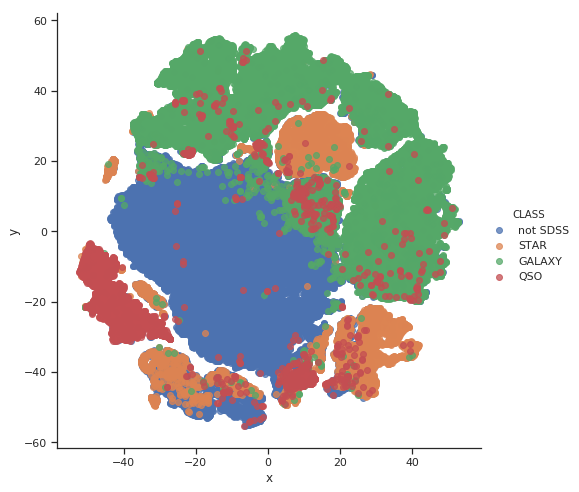

In [29]:
sns.lmplot('x', 'y', kids_merged, hue='CLASS', fit_reg=False, scatter_kws={'alpha': 0.75}, height=7)

In [30]:
def report_clusterer(data):
    #utworzenie nowego dataframe z 4 kolumnami
    report = pd.DataFrame(columns = ['GALAXY','QSO','STAR','not SDSS', 'SIZE'])
    #wybranie niepowtarzających się wartości z 'cluster'
    clusters = np.unique(data['cluster'])
    for cluster_id in clusters:
        cluster = data.loc[data['cluster'] == cluster_id]
        
        #zlicza ile jest elementow w danej klasie
        classes, counts = np.unique(cluster['CLASS'], return_counts=True)
        counts = counts/np.sum(counts)
        
        row = dict(zip(classes, counts))
        row['SIZE'] = cluster.shape[0]
        
        report = report.append(row, ignore_index=True)
        
    report.index = clusters
    return report

In [53]:
def plot(data, data_clustered, i):

    tmp = data.merge(data_clustered[['ID', 'cluster']], on='ID', how='left')
    
    
    tmp['cluster'] = tmp['cluster'].fillna(value='not clutstered')
    
    # print(tmp.columns)
    sns.lmplot('x', 'y', tmp, hue='cluster', fit_reg=False, scatter_kws={'alpha': 0.75}, height=7)
    plt.title("MAG_GAAP_r < %d" %(i))
    return
    

In [123]:
for i in range (16,30,1):
    for j in {i-4,4,i+4}:
    
        kids_x_sdss_cluster = clustering_parameters(kids_x_sdss,i,j)
        print('klastrowanie z parametrem: %d' %(i))
        print(get_class_dict(kids_x_sdss_cluster))
        print(report_clusterer(kids_x_sdss_cluster))

klastrowanie z parametrem: 16
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'GALAXY', 6: 'STAR', 7: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.319113  0.366604  0.314283       NaN  11181.0
 0       NaN       NaN  1.000000       NaN     66.0
 1       NaN       NaN  1.000000       NaN     34.0
 2  0.014493       NaN  0.985507       NaN     69.0
 3       NaN       NaN  1.000000       NaN     26.0
 4       NaN  1.000000       NaN       NaN    322.0
 5  0.994698  0.004349  0.000953       NaN  24141.0
 6  0.003860  0.000483  0.995657       NaN   4145.0
 7       NaN       NaN  1.000000       NaN     16.0
klastrowanie z parametrem: 16
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'STAR', 5: 'QSO', 6: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.216899  0.523630  0.259471       NaN   7681.0
 0       NaN       NaN  1.000000       NaN     69.0
 1       NaN  0.015385  0.984615       NaN     65.0
 2  0.018182     

klastrowanie z parametrem: 20
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'GALAXY', 5: 'STAR', 6: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.313770  0.371731  0.314499       NaN  10973.0
 0       NaN       NaN  1.000000       NaN     65.0
 1       NaN       NaN  1.000000       NaN     47.0
 2  0.020000       NaN  0.980000       NaN     50.0
 3  0.005848  0.994152       NaN       NaN    342.0
 4  0.994520  0.004409  0.001071       NaN  24269.0
 5       NaN       NaN  1.000000       NaN     25.0
 6  0.003783  0.000473  0.995744       NaN   4229.0
klastrowanie z parametrem: 20
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'STAR', 6: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.322898  0.369221  0.307881       NaN  10988.0
 0       NaN       NaN  1.000000       NaN     63.0
 1       NaN       NaN  1.000000       NaN     27.0
 2  0.022727       NaN  0.977273       NaN     44.0
 3       NaN       NaN  1.00

klastrowanie z parametrem: 24
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'QSO', 5: 'STAR', 6: 'GALAXY', 7: 'STAR', 8: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.290909  0.394258  0.314833       NaN  10450.0
 0       NaN       NaN  1.000000       NaN     78.0
 1       NaN  0.014085  0.985915       NaN     71.0
 2  0.012500       NaN  0.987500       NaN     80.0
 3       NaN  1.000000       NaN       NaN     86.0
 4       NaN  1.000000       NaN       NaN    205.0
 5       NaN       NaN  1.000000       NaN     27.0
 6  0.994367  0.004619  0.001013       NaN  24678.0
 7  0.004197  0.000466  0.995337       NaN   4289.0
 8       NaN       NaN  1.000000       NaN     36.0
klastrowanie z parametrem: 25
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'GALAXY', 5: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.276392  0.420645  0.302962       NaN   9823.0
 0       NaN       NaN  1.000000       NaN     59.0
 1       NaN      

klastrowanie z parametrem: 29
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'STAR', 3: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.316044  0.363261  0.320695       NaN  11394.0
 0       NaN       NaN  1.000000       NaN     56.0
 1  0.007117  0.992883       NaN       NaN    281.0
 2  0.004087  0.000481  0.995433       NaN   4160.0
 3  0.994566  0.004480  0.000954       NaN  24109.0


{-1: 'noise',
 0: 'STAR',
 1: 'STAR',
 2: 'STAR',
 3: 'STAR',
 4: 'QSO',
 5: 'GALAXY',
 6: 'STAR',
 7: 'STAR'}

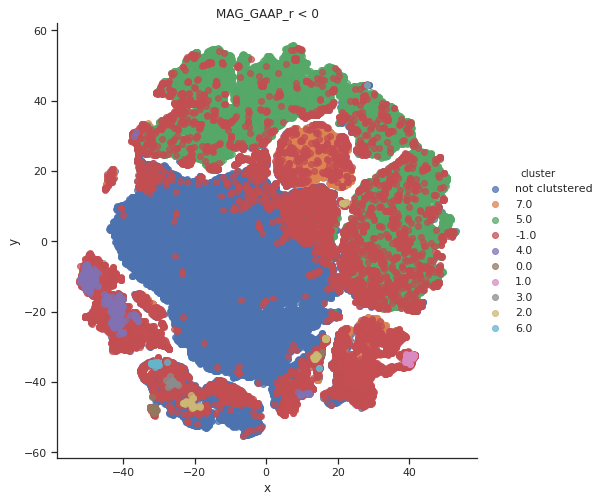

In [125]:
kids_x_sdss_cluster = clustering_parameters(kids_x_sdss,16,16)
plot(kids_merged, kids_x_sdss_cluster,0)
get_class_dict(kids_x_sdss_cluster)

{-1: 'noise',
 0: 'STAR',
 1: 'STAR',
 2: 'STAR',
 3: 'QSO',
 4: 'GALAXY',
 5: 'STAR',
 6: 'STAR'}

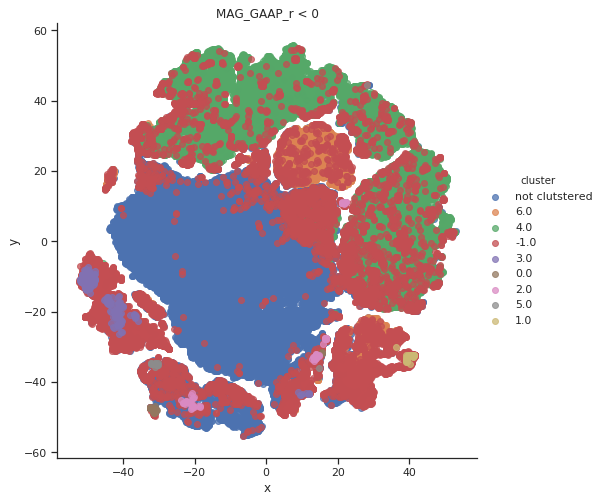

In [126]:
kids_x_sdss_cluster = clustering_parameters(kids_x_sdss,19,19)
plot(kids_merged, kids_x_sdss_cluster,0)
get_class_dict(kids_x_sdss_cluster)

{-1: 'noise',
 0: 'STAR',
 1: 'STAR',
 2: 'STAR',
 3: 'STAR',
 4: 'QSO',
 5: 'STAR',
 6: 'GALAXY'}

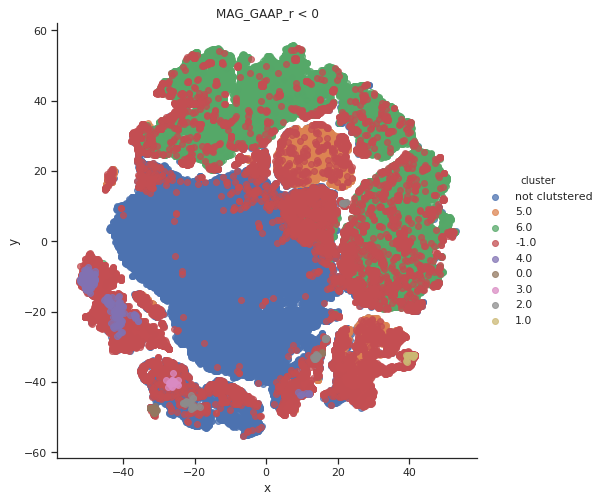

In [128]:
kids_x_sdss_cluster = clustering_parameters(kids_x_sdss,22,22)
plot(kids_merged, kids_x_sdss_cluster,0)
get_class_dict(kids_x_sdss_cluster)

{-1: 'noise',
 0: 'STAR',
 1: 'STAR',
 2: 'STAR',
 3: 'QSO',
 4: 'GALAXY',
 5: 'STAR',
 6: 'STAR'}

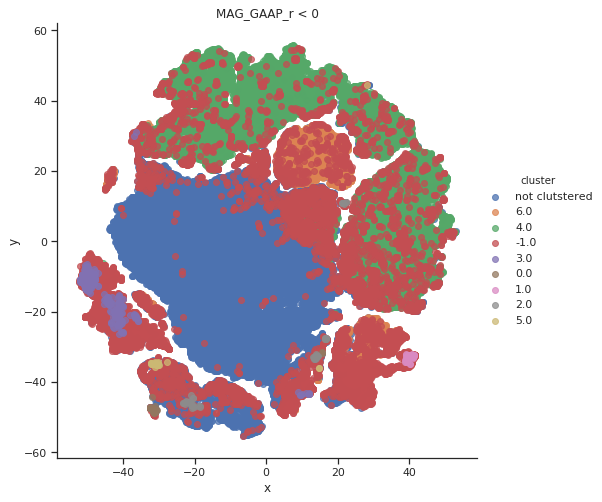

In [129]:
kids_x_sdss_cluster = clustering_parameters(kids_x_sdss,22,16)
plot(kids_merged, kids_x_sdss_cluster,0)
get_class_dict(kids_x_sdss_cluster)

klastrowanie z parametrem: 16
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'GALAXY', 6: 'STAR', 7: 'STAR'}
klastrowanie z parametrem: 17
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'GALAXY', 6: 'STAR', 7: 'STAR'}
klastrowanie z parametrem: 18
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'GALAXY', 5: 'STAR', 6: 'STAR'}
klastrowanie z parametrem: 19
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'GALAXY', 5: 'STAR', 6: 'STAR'}
klastrowanie z parametrem: 20
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'STAR', 6: 'GALAXY'}
klastrowanie z parametrem: 21
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'STAR', 6: 'GALAXY'}
klastrowanie z parametrem: 22
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'STAR', 6: 'GALAXY'}
klastrowanie z parametrem: 23
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'QSO', 5: 'STAR', 6: 'GALAXY'}
kl

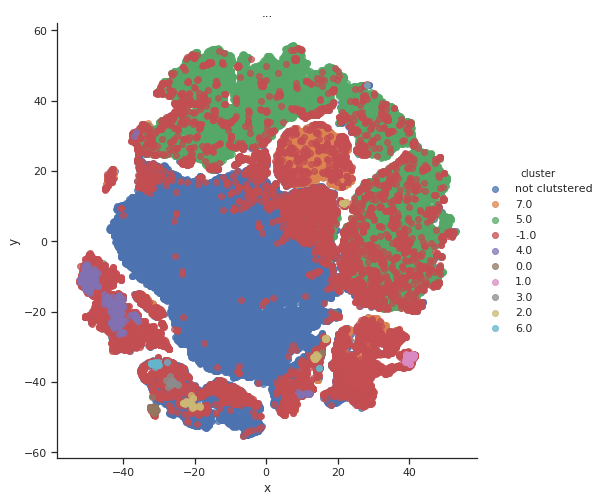

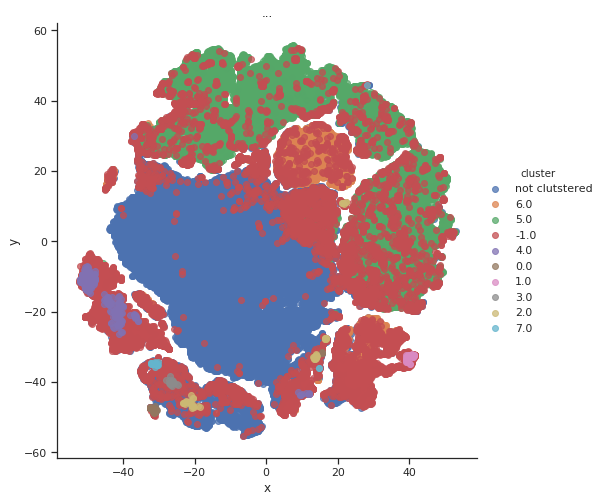

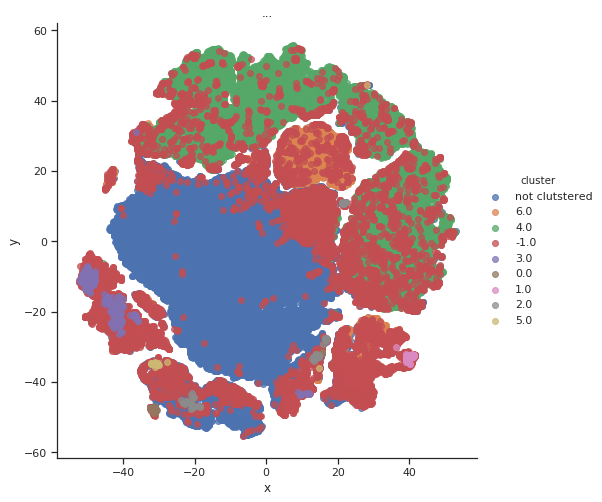

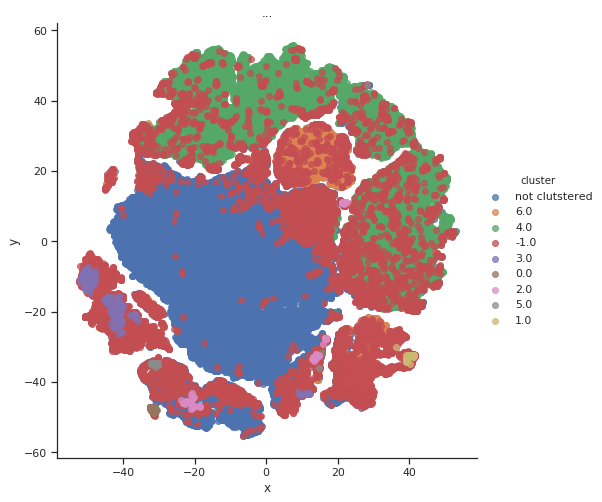

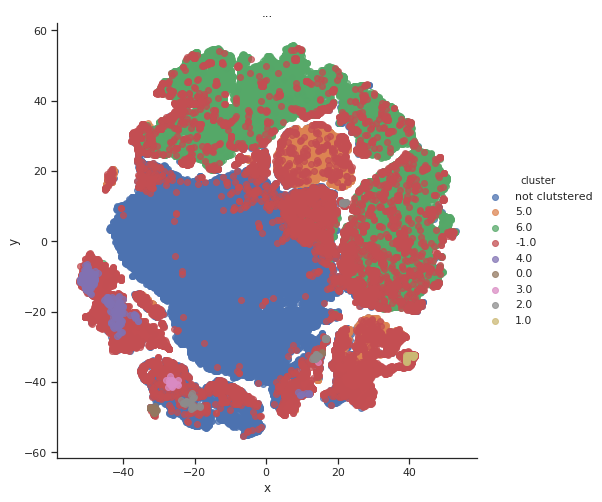

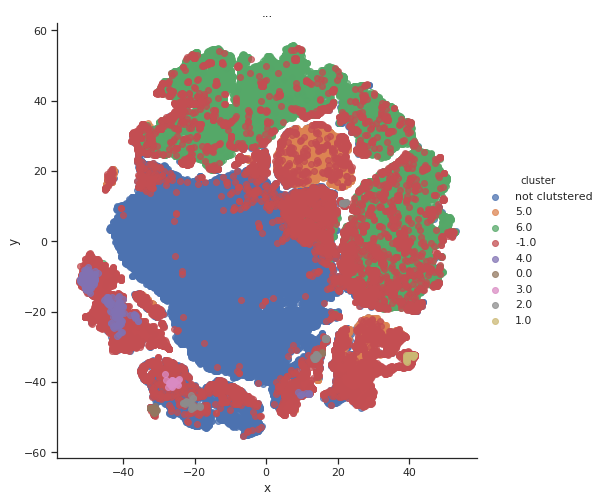

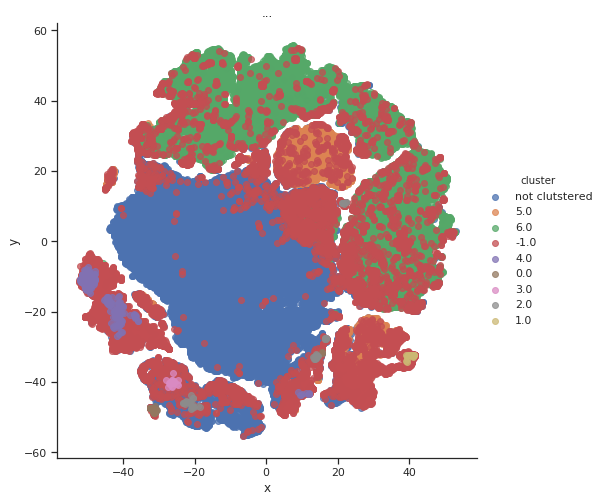

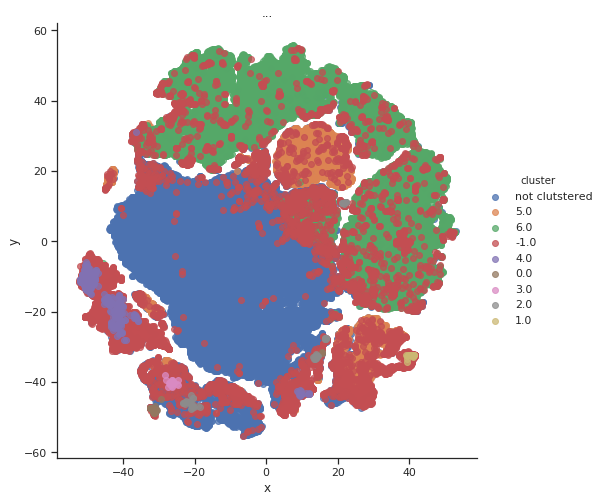

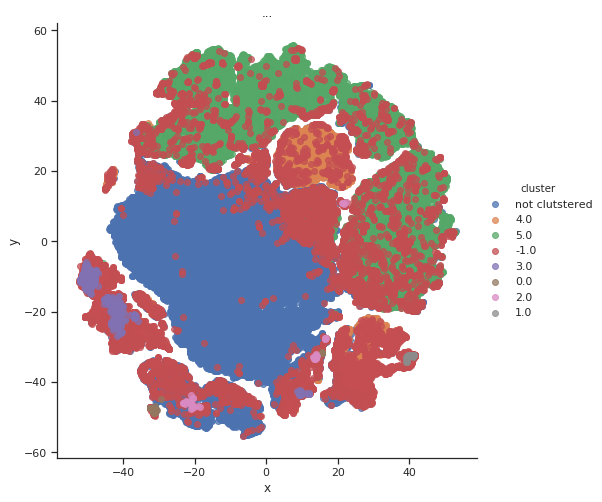

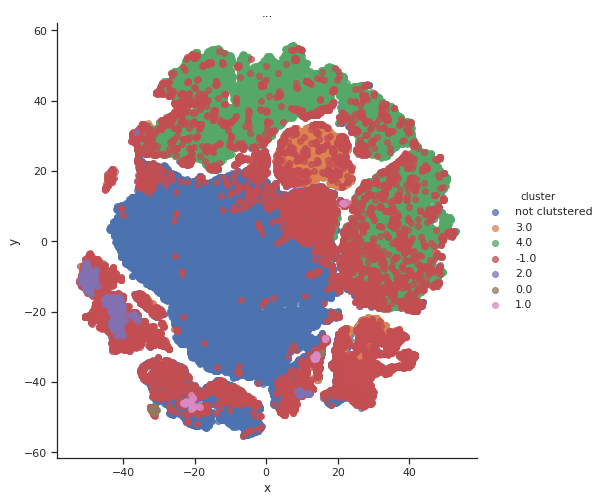

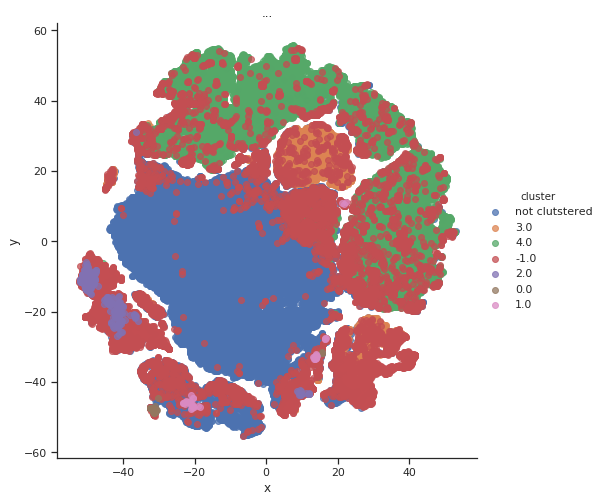

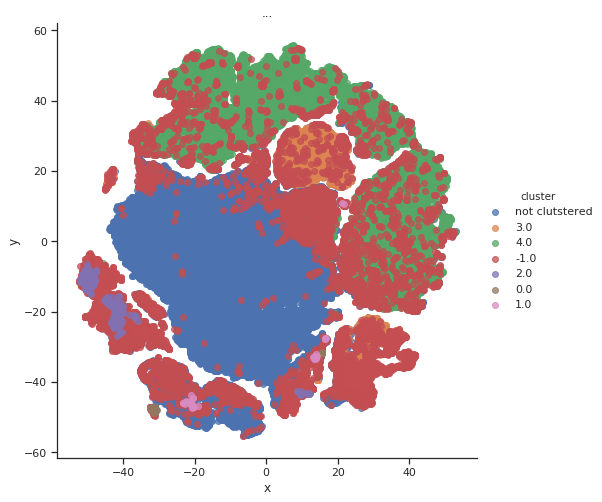

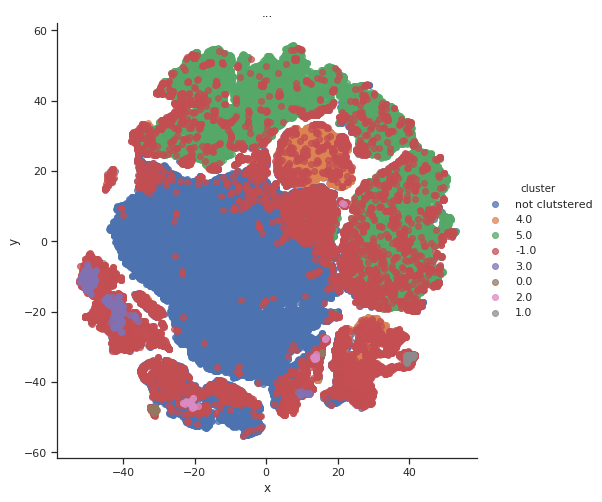

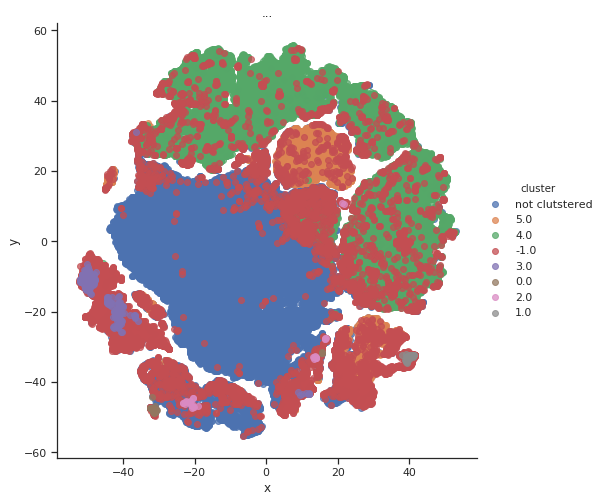

In [161]:
for i in range (16,30,1):

    kids_x_sdss_cluster = clustering_parameters(kids_x_sdss,i,None)
    print('klastrowanie z parametrem: %d' %(i))
    print(get_class_dict(kids_x_sdss_cluster))
    plot(kids_merged, kids_x_sdss_cluster)

In [50]:
for i in range (13,25,1):

    kids_x_sdss_cluster = clustering(kids_x_sdss,i)
    print('klastrowanie z parametrem: %d' %(i))
    print(get_class_dict(kids_x_sdss_cluster))
    print(report_clusterer(kids_x_sdss_cluster))

klastrowanie z parametrem: 13
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.346528  0.419857  0.233615       NaN   1541.0
 0  0.005847  0.325690  0.668463       NaN  10946.0
 1  0.196721  0.016393  0.786885       NaN     61.0
 2  0.983098  0.011475  0.005428       NaN  27452.0
klastrowanie z parametrem: 14
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.339647  0.421293  0.239059       NaN   1531.0
 0  0.005847  0.325690  0.668463       NaN  10946.0
 1  0.209677  0.032258  0.758065       NaN     62.0
 2  0.983249  0.011507  0.005244       NaN  27461.0
klastrowanie z parametrem: 15
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.338794  0.422018  0.239187       NaN   1526.0
 0  0.005847  0.325690  0.668463       NaN  10946.0
 1  0.183333  0.033333  0.783333       NaN     60.0
 2  0.983180  0.011541  0.005279   

In [137]:
#parameters to clustering 22,16
def function(i):
    kids_1 = kids.loc[kids['MAG_GAAP_r'] < i]
    kids_merged_1 = pd.concat([kids_1, kids_x_sdss], sort=False)
    kids_merged_1 = clustering(kids_merged_1)
    print(kids_1.shape)
    print(get_class_dict(kids_merged_1))
    plot(kids_merged, kids_merged_1,i)
    
    print(report_clusterer(kids_merged_1))

(829, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'STAR', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.322326  0.382552  0.281614  0.013508  10660.0
 0       NaN       NaN  1.000000       NaN     65.0
 1       NaN       NaN  1.000000       NaN     47.0
 2  0.012195       NaN  0.987805       NaN     82.0
 3  0.002933  0.997067       NaN       NaN    341.0
 4  0.003385  0.000564  0.875306  0.120745   5317.0
 5  0.992803  0.004400  0.001028  0.001768  24317.0


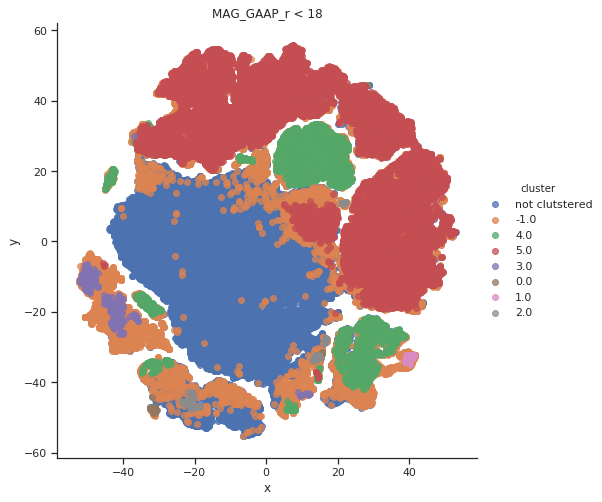

In [55]:
function(18)

(1159, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'STAR', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.322978  0.381955  0.275686  0.019381  10784.0
 0       NaN       NaN  1.000000       NaN     65.0
 1       NaN       NaN  1.000000       NaN     42.0
 2  0.012195       NaN  0.987805       NaN     82.0
 3       NaN  1.000000       NaN       NaN    300.0
 4  0.003590  0.000539  0.841321  0.154550   5571.0
 5  0.990911  0.004359  0.001069  0.003660  24315.0


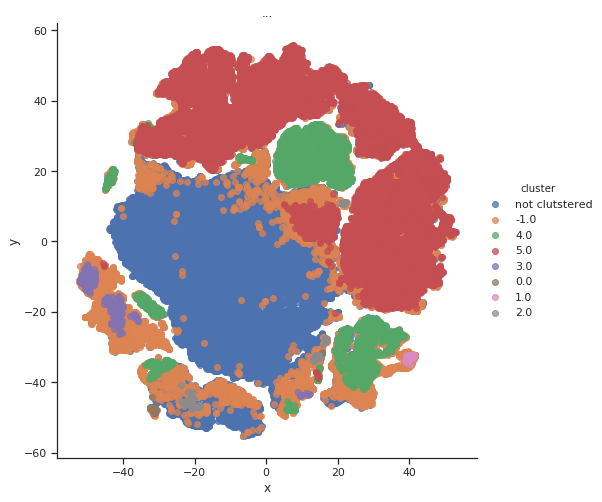

In [35]:
function(18.5)

(1675, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'STAR', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.318441  0.381504  0.269075  0.030980  10878.0
 0       NaN       NaN  1.000000       NaN     63.0
 1       NaN       NaN  0.977273  0.022727     44.0
 2  0.012346       NaN  0.987654       NaN     81.0
 3       NaN  0.992620       NaN  0.007380    271.0
 4  0.003391  0.000509  0.802815  0.193286   5898.0
 5  0.986620  0.004337  0.001064  0.007979  24440.0


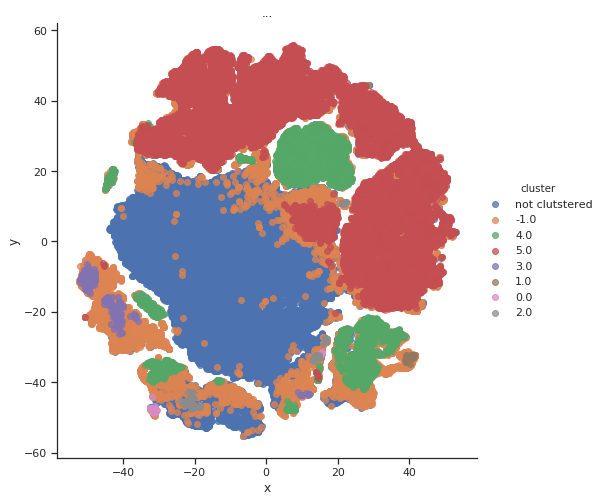

In [36]:
function(19)

(2320, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'GALAXY', 5: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.225958  0.491203  0.249819  0.033020   8298.0
 0       NaN       NaN  0.974359  0.025641     39.0
 1       NaN       NaN  0.977273  0.022727     44.0
 2  0.012195       NaN  0.987805       NaN     82.0
 3       NaN  0.992620       NaN  0.007380    271.0
 4  0.975700  0.006569  0.001405  0.016327  26337.0
 5  0.003449  0.001380  0.772796  0.222376   7249.0


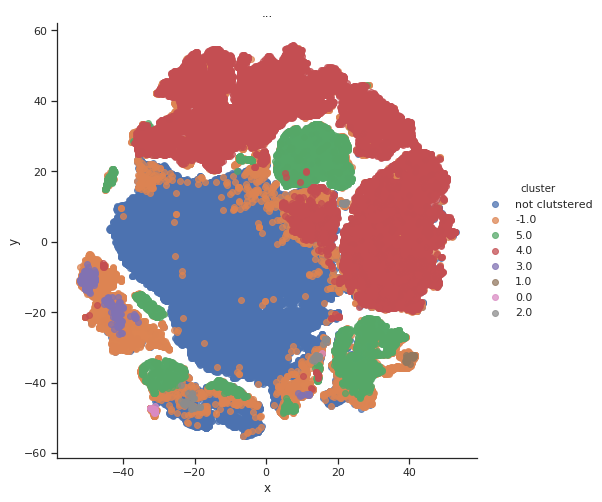

In [37]:
function(19.5)

(3218, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'QSO', 4: 'STAR', 5: 'GALAXY', 6: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.388958  0.322317  0.204355  0.084370  12860.0
 0       NaN       NaN  0.954545  0.045455     22.0
 1       NaN       NaN  0.980392  0.019608     51.0
 2  0.018182       NaN  0.981818       NaN     55.0
 3       NaN  0.993266       NaN  0.006734    297.0
 4  0.003314  0.000864  0.735485  0.260337   6941.0
 5  0.090909       NaN       NaN  0.909091     22.0
 6  0.982586  0.003570  0.000697  0.013148  22970.0


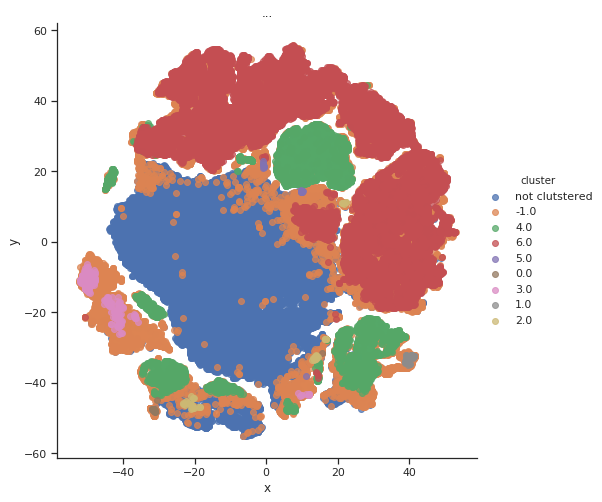

In [38]:
function(20)

(4414, 307)
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'QSO', 3: 'STAR', 4: 'GALAXY', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.374442  0.291977  0.194493  0.139088  14782.0
 0       NaN       NaN  0.980392  0.019608     51.0
 1       NaN  0.977778       NaN  0.022222     90.0
 2       NaN  0.976744       NaN  0.023256     43.0
 3  0.003199  0.000727  0.717609  0.278464   6877.0
 4  0.056338  0.014085       NaN  0.929577     71.0
 5  0.979422  0.003378  0.000622  0.016578  22500.0


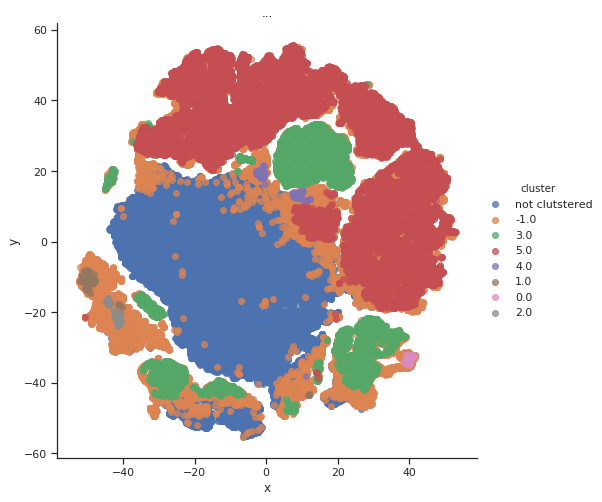

In [39]:
function(20.5)

(6080, 307)
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'QSO', 3: 'STAR', 4: 'STAR', 5: 'STAR', 6: 'STAR', 7: 'STAR', 8: 'STAR', 9: 'GALAXY', 10: 'GALAXY'}
       GALAXY       QSO      STAR  not SDSS     SIZE
-1   0.306718  0.215294  0.241230  0.236758  20126.0
 0        NaN       NaN  0.980392  0.019608     51.0
 1        NaN  0.977778       NaN  0.022222     90.0
 2        NaN  0.976744       NaN  0.023256     43.0
 3        NaN       NaN  0.034483  0.965517     29.0
 4        NaN       NaN  0.301887  0.698113     53.0
 5        NaN       NaN  0.258065  0.741935     31.0
 6        NaN       NaN  0.400000  0.600000     25.0
 7   0.003067       NaN  0.809590  0.187343   3587.0
 8        NaN       NaN  0.542857  0.457143     35.0
 9   0.040541  0.013514       NaN  0.945946     74.0
 10  0.976067  0.002918  0.000501  0.020514  21936.0


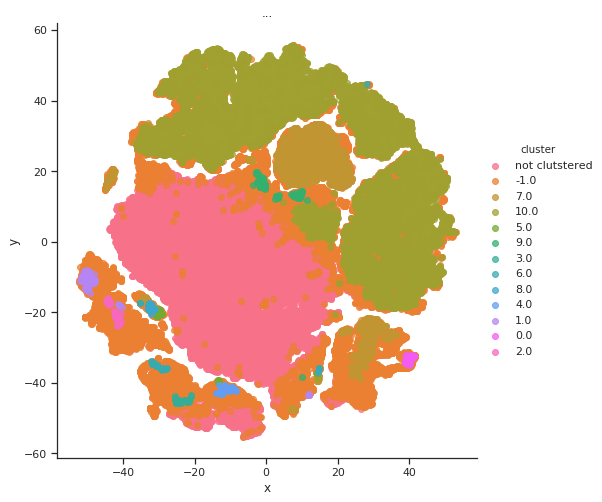

In [40]:
function(21)

(8262, 307)
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'STAR', 3: 'GALAXY', 4: 'GALAXY', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.364780  0.239555  0.120901  0.274764  17808.0
 0       NaN       NaN  0.983607  0.016393     61.0
 1       NaN  0.979592       NaN  0.020408    196.0
 2  0.003060  0.001295  0.664941  0.330705   8497.0
 3  0.974157  0.002681  0.000509  0.022653  21631.0
 4  0.076923  0.038462       NaN  0.884615     26.0
 5  0.046512       NaN       NaN  0.953488     43.0


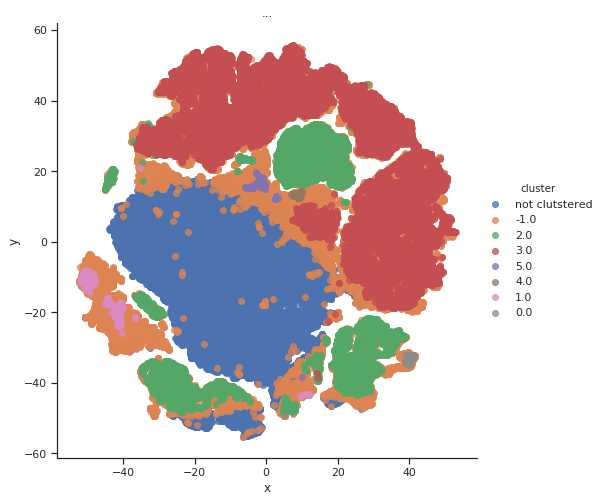

In [41]:
function(21.5)

(11313, 307)
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'QSO', 3: 'STAR', 4: 'GALAXY', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.287407  0.206025  0.117790  0.388778  21012.0
 0       NaN       NaN  0.983607  0.016393     61.0
 1       NaN  0.977273       NaN  0.022727     44.0
 2       NaN  0.977273       NaN  0.022727     88.0
 3  0.003058  0.000892  0.678685  0.317365   7849.0
 4  0.042105  0.010526       NaN  0.947368     95.0
 5  0.971440  0.002797  0.000541  0.025221  22164.0


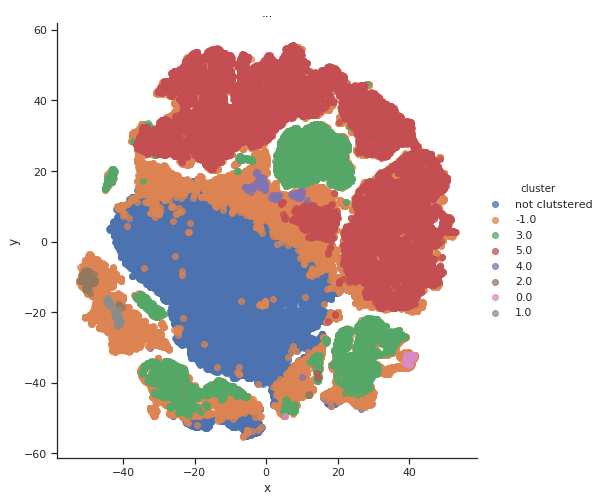

In [42]:
function(22)

(15553, 307)
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'QSO', 3: 'STAR', 4: 'GALAXY', 5: 'GALAXY', 6: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.254499  0.171797  0.089176  0.484528  25175.0
 0       NaN       NaN  0.983871  0.016129     62.0
 1       NaN  0.977778       NaN  0.022222     45.0
 2       NaN  0.978261       NaN  0.021739     92.0
 3  0.003114  0.001198  0.665509  0.330180   8350.0
 4  0.037037       NaN       NaN  0.962963     54.0
 5  0.076923  0.038462       NaN  0.884615     26.0
 6  0.972964  0.002667  0.000506  0.023863  21749.0


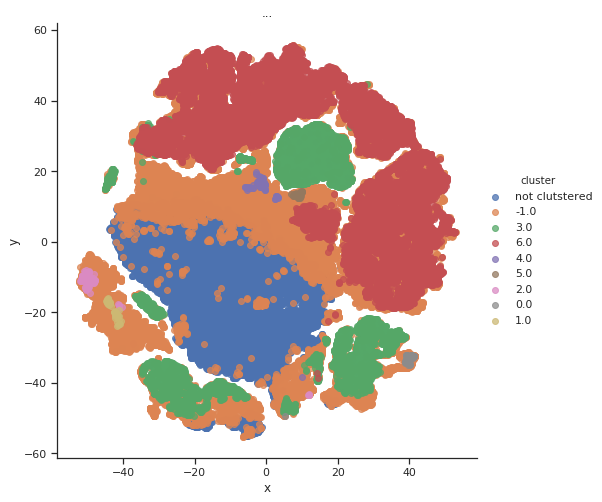

In [43]:
function(22.5)

(21106, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.046003  0.239039  0.104715  0.610243   7869.0
 0       NaN       NaN  0.766667  0.233333     30.0
 1       NaN       NaN  0.985714  0.014286     70.0
 2  0.512562  0.049815  0.130945  0.306679  53137.0


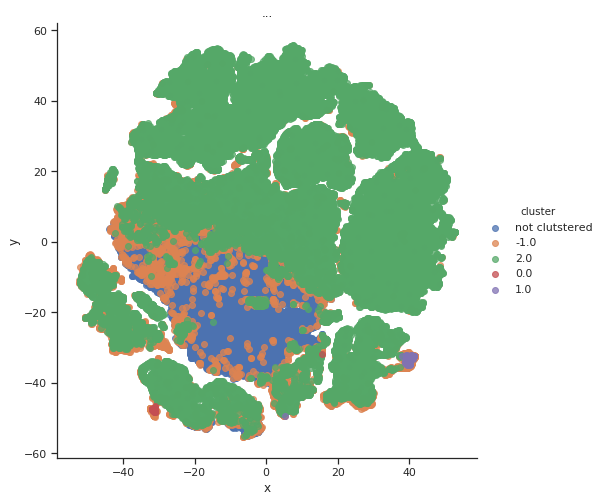

In [44]:
function(23)

(21106, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'QSO', 4: 'QSO', 6: 'GALAXY', 7: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.092183  0.182730  0.088471  0.636617  22629.0
 0       NaN  0.020000  0.960000  0.020000    100.0
 1       NaN       NaN  0.794872  0.205128     39.0
 2  0.012821  0.961538       NaN  0.025641     78.0
 3       NaN  1.000000       NaN       NaN     24.0
 4       NaN  0.983871       NaN  0.016129    124.0
 5       NaN       NaN       NaN  1.000000     24.0
 6  0.867461  0.005480  0.001191  0.125868  29380.0
 7  0.002871  0.001034  0.655719  0.340377   8708.0


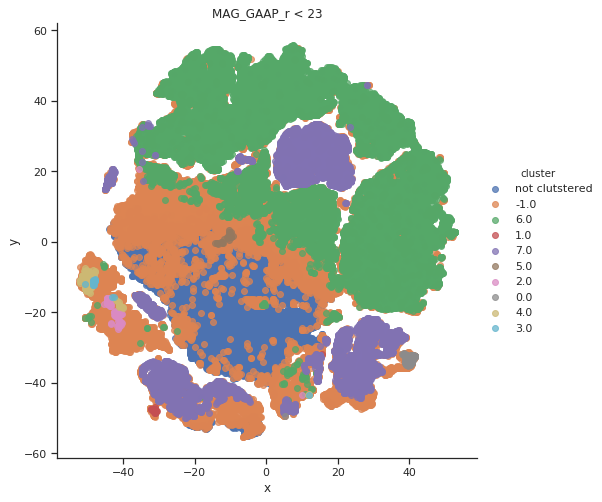

In [70]:
function2(23,22,5)

(28071, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.028798  0.151784  0.066534  0.752884  13091.0
 0       NaN       NaN  0.986301  0.013699     73.0
 1       NaN       NaN  0.727273  0.272727     22.0
 2  0.495964  0.046297  0.125991  0.331748  54885.0


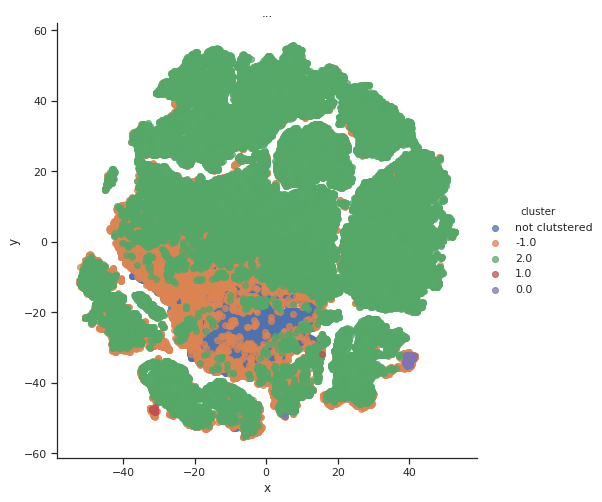

In [45]:
function(23.5)

(28071, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'QSO', 4: 'QSO', 6: 'STAR', 7: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.089665  0.126425  0.074783  0.709127  32454.0
 0       NaN  0.011364  0.965909  0.022727     88.0
 1       NaN       NaN  0.787879  0.212121     33.0
 2       NaN  1.000000       NaN       NaN     24.0
 3  0.011905  0.952381       NaN  0.035714     84.0
 4  0.010256  0.974359       NaN  0.015385    195.0
 5       NaN       NaN       NaN  1.000000     26.0
 6  0.003069  0.001023  0.678645  0.317263   7820.0
 7  0.901781  0.004461  0.001060  0.092698  27347.0


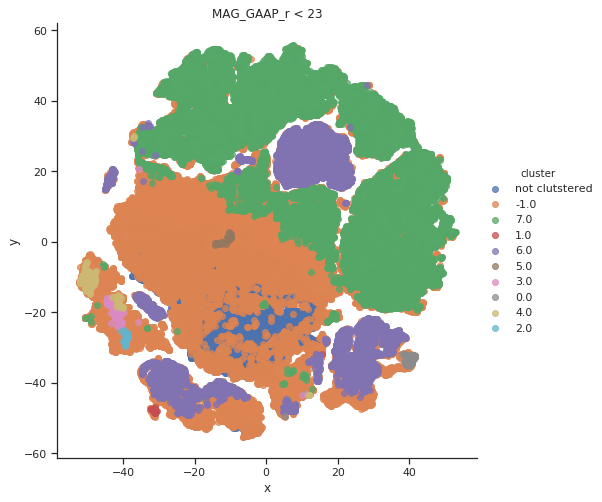

In [82]:
function2(23.5,22,6)

(35042, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.019162  0.101725  0.045990  0.833123  18265.0
 0       NaN       NaN  0.772727  0.227273     22.0
 1       NaN  0.014493  0.971014  0.014493     69.0
 2  0.480683  0.047084  0.122605  0.349628  56686.0


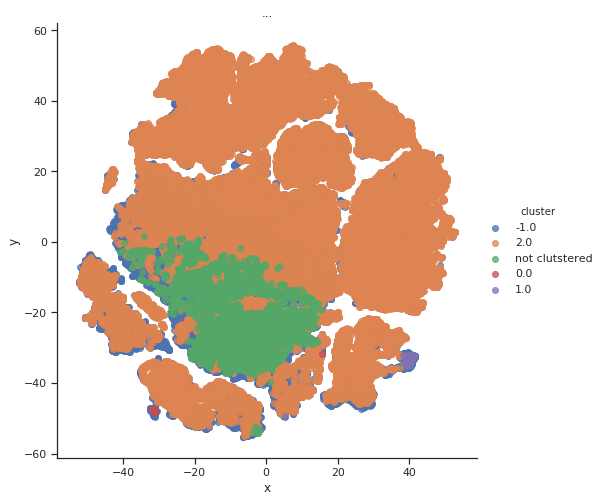

In [46]:
function(24)

(35042, 307)
{-1: 'noise', 0: 'STAR', 1: 'QSO', 2: 'STAR', 3: 'STAR', 4: 'QSO', 6: 'STAR', 7: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.026895  0.113069  0.043328  0.816708  26957.0
 0       NaN       NaN  1.000000       NaN     22.0
 1       NaN  1.000000       NaN       NaN     26.0
 2       NaN       NaN  0.041667  0.958333     24.0
 3       NaN  0.021053  0.957895  0.021053     95.0
 4       NaN  1.000000       NaN       NaN     26.0
 5       NaN       NaN       NaN  1.000000     25.0
 6       NaN       NaN  0.607143  0.392857     28.0
 7  0.561738  0.029808  0.137440  0.271013  47839.0


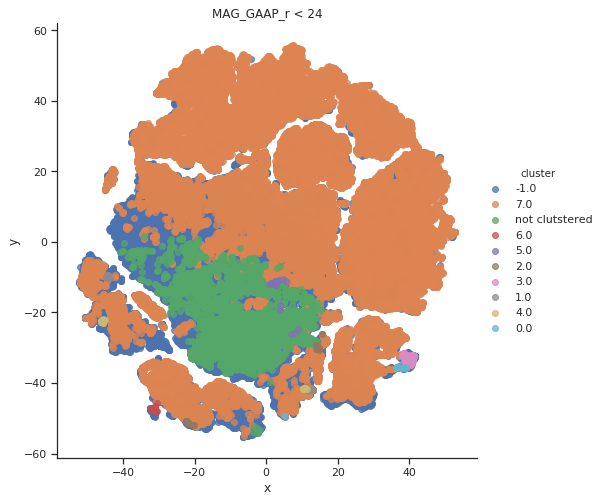

In [109]:
function2(24,22,2)

(39030, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'STAR', 4: 'GALAXY', 5: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.124469  0.087580  0.047927  0.740025  48470.0
 0       NaN       NaN  0.782609  0.217391     23.0
 1       NaN  0.014085  0.971831  0.014085     71.0
 2       NaN  0.976303       NaN  0.023697    211.0
 3  0.003007  0.001253  0.683037  0.312704   7982.0
 4  0.024390       NaN       NaN  0.975610     82.0
 5  0.970619  0.002974  0.000541  0.025866  22191.0


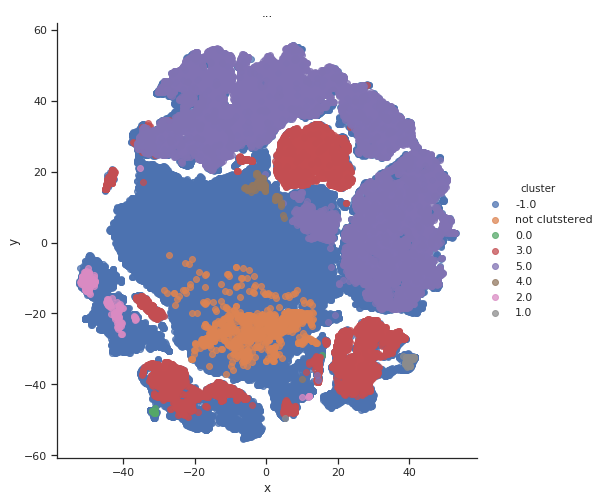

In [47]:
function(24.5)

(39925, 307)
{-1: 'noise', 0: 'STAR', 1: 'GALAXY', 2: 'STAR'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.015247  0.081187  0.036050  0.867517  23218.0
 0       NaN  0.013889  0.972222  0.013889     72.0
 1  0.481232  0.046668  0.122763  0.349337  56613.0
 2       NaN       NaN  0.772727  0.227273     22.0


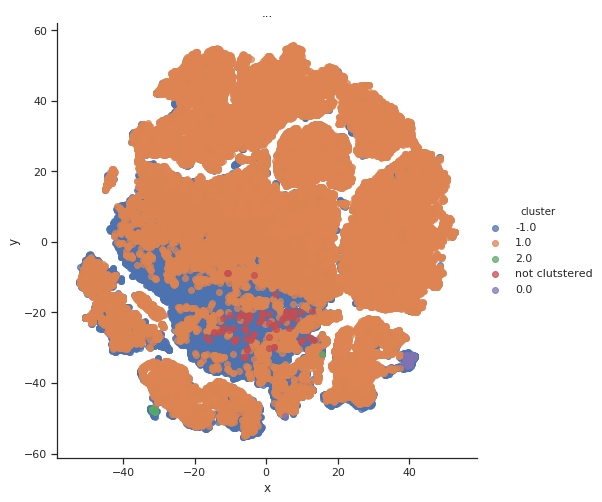

In [48]:
function(25)

(39925, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'QSO', 4: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.044269  0.107461  0.033981  0.814289  38786.0
 0       NaN       NaN  0.980000  0.020000     50.0
 1  0.003474  0.003860  0.623697  0.368970  10364.0
 2       NaN  0.980952       NaN  0.019048    105.0
 3       NaN  0.958333       NaN  0.041667     48.0
 4  0.845381  0.005593  0.001407  0.147619  30572.0


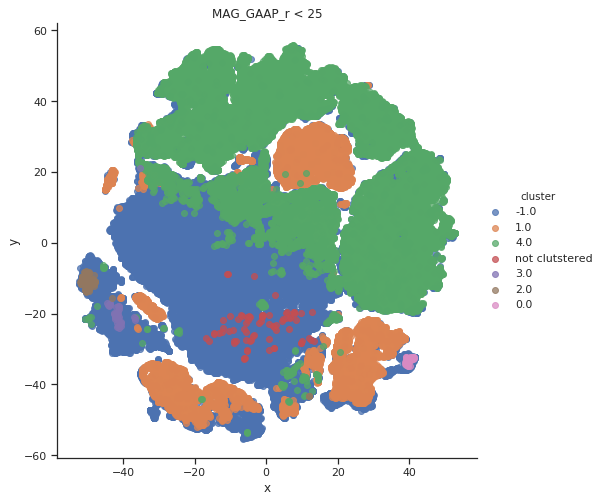

In [66]:
function2(25,22,22)

(39996, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.015055  0.079770  0.035739  0.869436  22916.0
 0       NaN       NaN  0.793103  0.206897     29.0
 1       NaN  0.013699  0.972603  0.013699     73.0
 2  0.478307  0.047369  0.122170  0.352153  56978.0


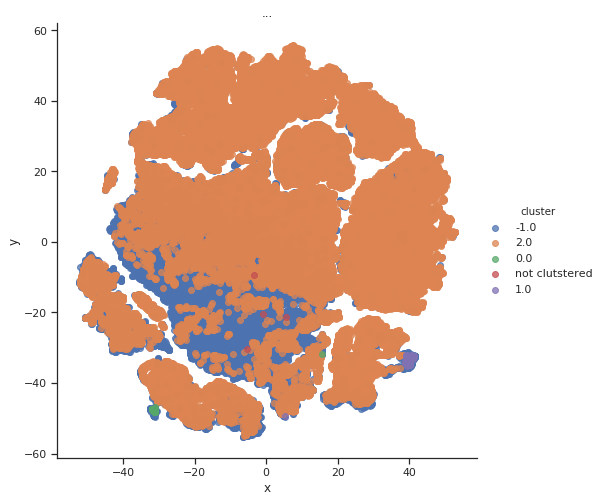

In [49]:
function(25.5)

(39996, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'GALAXY', 4: 'QSO', 5: 'QSO'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.037911  0.104313  0.043334  0.814443  38538.0
 0       NaN       NaN  0.794872  0.205128     39.0
 1       NaN  0.025974  0.948052  0.025974     77.0
 2       NaN  1.000000       NaN       NaN     26.0
 3  0.636330  0.005892  0.148516  0.209262  41073.0
 4  0.014925  0.970149       NaN  0.014925     67.0
 5       NaN  0.982955       NaN  0.017045    176.0


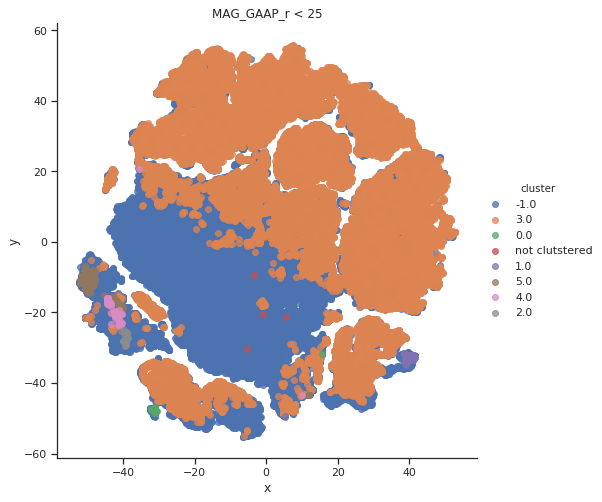

In [121]:
function2(25.5,22,5)

(40000, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'STAR', 4: 'STAR', 5: 'STAR', 6: 'STAR', 7: 'STAR', 8: 'GALAXY', 9: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.113110  0.079277  0.084282  0.723331  53143.0
 0       NaN       NaN  0.766667  0.233333     30.0
 1       NaN  0.013699  0.972603  0.013699     73.0
 2       NaN  0.980237       NaN  0.019763    253.0
 3       NaN       NaN  0.115385  0.884615     26.0
 4       NaN       NaN  0.333333  0.666667     51.0
 5       NaN       NaN  0.431373  0.568627     51.0
 6       NaN       NaN  0.540000  0.460000     50.0
 7  0.002747       NaN  0.803995  0.193258   4005.0
 8  0.970403  0.002969  0.000540  0.026089  22232.0
 9  0.023256       NaN       NaN  0.976744     86.0


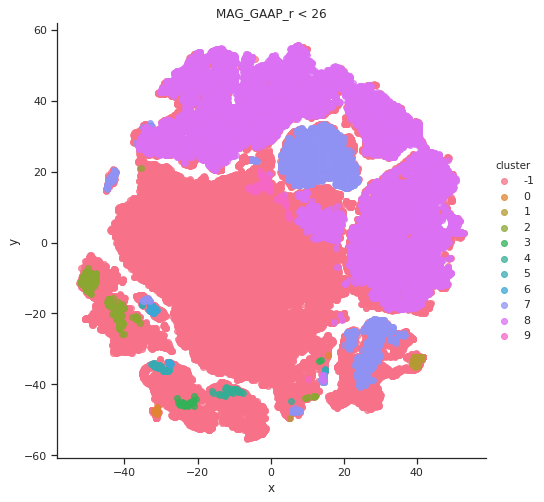

In [138]:
function(26)

(40000, 307)
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'QSO', 3: 'STAR', 4: 'STAR', 5: 'STAR', 6: 'STAR', 7: 'STAR', 8: 'GALAXY', 9: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.113110  0.079277  0.084282  0.723331  53143.0
 0       NaN       NaN  0.766667  0.233333     30.0
 1       NaN  0.013699  0.972603  0.013699     73.0
 2       NaN  0.980237       NaN  0.019763    253.0
 3       NaN       NaN  0.115385  0.884615     26.0
 4       NaN       NaN  0.333333  0.666667     51.0
 5       NaN       NaN  0.431373  0.568627     51.0
 6       NaN       NaN  0.540000  0.460000     50.0
 7  0.002747       NaN  0.803995  0.193258   4005.0
 8  0.970403  0.002969  0.000540  0.026089  22232.0
 9  0.023256       NaN       NaN  0.976744     86.0


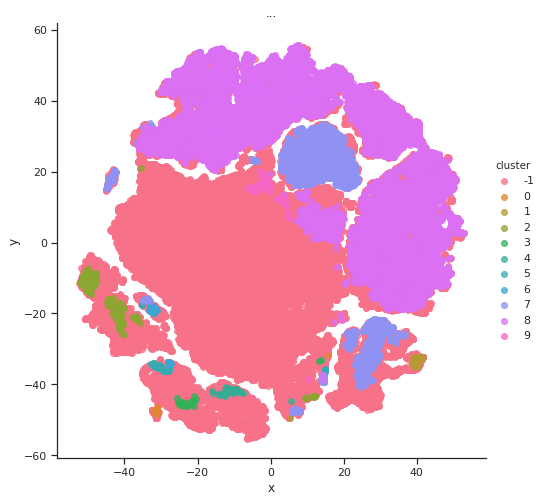

In [51]:
function(26.5)

In [59]:
#i - range Mag_r; j,k - parameters to clustering
def function2(i,j,k):
    kids_1 = kids.loc[kids['MAG_GAAP_r'] < i]
    kids_merged_1 = pd.concat([kids_1, kids_x_sdss], sort=False)
    kids_merged_1 = clustering_parameters(kids_merged_1,j,k)
    print(kids_1.shape)
    print(get_class_dict(kids_merged_1))
    plot(kids_merged, kids_merged_1,i)
    
    print(report_clusterer(kids_merged_1))

In [132]:
for i in range (16,30,1):
    for j in {i-4,4,i+4}:
    
        kids_merged_5_cluster2 = clustering_parameters(kids_merged_5,i,j)
        print('klastrowanie z parametrem: %d' %(i))
        print(get_class_dict(kids_merged_5_cluster2))
        print(report_clusterer(kids_merged_5_cluster2))


klastrowanie z parametrem: 16
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.287812  0.411894  0.229075  0.071219   1362.0
 0  0.005166  0.270953  0.553715  0.170166  12194.0
 1  0.164557  0.050633  0.746835  0.037975     79.0
 2  0.951830  0.012024  0.005538  0.030609  26365.0
klastrowanie z parametrem: 16
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.374219  0.353776  0.207269  0.064736   1761.0
 0  0.005166  0.270931  0.553752  0.170152  12195.0
 1  0.162162  0.027027  0.743243  0.067568     74.0
 2       NaN       NaN  1.000000       NaN     43.0
 3  0.957650  0.009912  0.002044  0.030393  25927.0
klastrowanie z parametrem: 16
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'STAR', 4: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.433333  0.325758  0.184343  0.056566   1980.0
 0  0.005247  0.270886  0.553661  0.170206  12197.0
 1

      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.355450  0.362559  0.214455  0.067536   1688.0
 0  0.005166  0.270953  0.553715  0.170166  12194.0
 1  0.189873  0.037975  0.734177  0.037975     79.0
 2  0.027778       NaN  0.972222       NaN     36.0
 3  0.956967  0.010268  0.002384  0.030381  26003.0
klastrowanie z parametrem: 23
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'STAR', 3: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.429644  0.322984  0.187281  0.060090   1997.0
 0  0.005247  0.270886  0.553661  0.170206  12197.0
 1       NaN  0.031250  0.859375  0.109375     64.0
 2       NaN       NaN  1.000000       NaN     26.0
 3  0.958197  0.009138  0.002372  0.030292  25716.0
klastrowanie z parametrem: 24
{-1: 'noise', 0: 'STAR', 1: 'STAR', 2: 'GALAXY', 3: 'GALAXY'}
      GALAXY       QSO      STAR  not SDSS     SIZE
-1  0.669419  0.142678  0.081658  0.106246   5572.0
 0  0.005167  0.270975  0.553760  0.170098  12193.0
 1  0.100000  0.020000  0.860000  0.02

In [75]:
#kids_1 = kids.loc[(kids['MAG_GAAP_r'] < 22.5) & (kids['MAG_GAAP_r'] > 22)]